In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(legacy='1.25')
abtem.config.set({"local_diagnostics.progress_bar": False});

(appendix:antialiasing)=
# Sampling and antialiasing

## Sampling
In *ab*TEM, the wave function is represented on a rectangular grid of $N_x \times N_y$ grid points (`gpts`) or pixels. Given an orthogonal cell with the sidelengths $L_x$ and $L_y$, in the $x$ and $y$-direction, the real-space sampling (or dimensions of the pixels) is $\Delta x = L_x / N_x$ in $x$ and $\Delta y=L_y / N_y$.
The real-space coordinates thus take on only discrete values of

$$
    x_i = i \Delta x \quad i = 0,1, \ldots , N_x - 1, \\
    y_j = j \Delta y \quad j = 0,1, \ldots , N_y - 1. \\ 
$$

The Fourier transform of this grid of values (for example, a simulated image) will also have $N_x \times N_y$ grid points. However, in reciprocal space, the sampling is instead determined by the supercell dimensions (real-space extent of the potential) given by the inverse relations $\Delta k_x = 1/L_x$ and $\Delta k_y = 1/L_y$. The reciprocal space coordinates thus take on values

$$
    k_{x,i} = - k_{x,\mathrm{max}} + i \Delta k_x, \\
    k_{x,j} = - k_{y,\mathrm{max}} + j \Delta k_y,
$$

where the maximum spatial frequencies (reciprocal-space extent) are imposed by the real-space sampling

$$ 
    k_{x,\mathrm{max}} = \frac{1}{2\Delta_x} \quad \mathrm{and} \quad k_{y,\mathrm{max}} = \frac{1}{2\Delta_y} \quad .
$$

We demonstrate the relationship between the real space sampling and the maximum simulated spatial frequencies ($k_{x,\mathrm{max}}$ and $k_{y,\mathrm{max}}$) in *ab*TEM below. 

We simulate two otherwise identical exit wave functions at different (uniform) samplings of $\Delta=\Delta_x=\Delta_y=0.08 \ \mathrm{Å}$ and $\Delta= 0.04 \ \mathrm{Å}$.

In [2]:
atoms = ase.build.bulk("Au", cubic=True) * (5, 5, 40)

exit_wave_rough = abtem.Probe(
    energy=100e3, semiangle_cutoff=9.5, sampling=0.08
).multislice(atoms)

exit_wave_fine = abtem.Probe(
    energy=100e3, semiangle_cutoff=9.5, sampling=0.04
).multislice(atoms)

We plot the diffraction patterns on a power scale to relatively enhance the intensity at high scattering angle.

You should note that the maximum spatial frequency on the plot axes is doubled in the figure with the fine sampling.

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

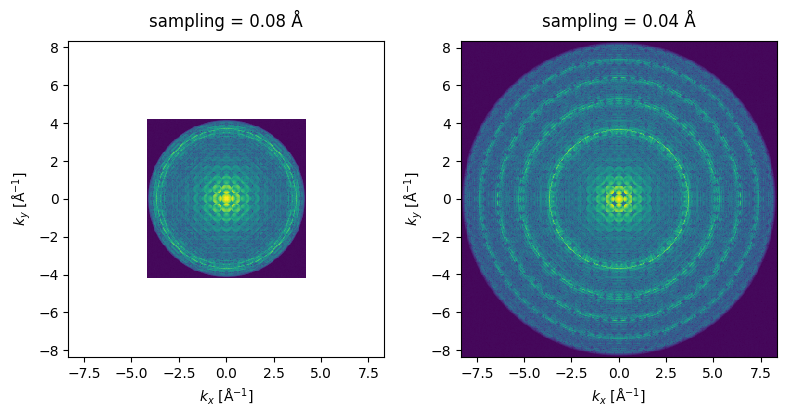

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

exit_wave_rough.diffraction_patterns().show(
    ax=ax1, power=0.1, title="sampling = 0.08 Å"
)
exit_wave_fine.diffraction_patterns().show(
    ax=ax2, power=0.1, title="sampling = 0.04 Å"
)

# Set the extent of the roughly sampled patterns to match the finely sampled.
ext = exit_wave_fine.diffraction_patterns().extent[0]/2
ax1.set_xlim(ext, -ext)
ax1.set_ylim(ext, -ext)

plt.tight_layout()

## Antialiasing
You should also note that even though we are plotting the diffraction patterns on a power scale, the intensity goes to zero rather abruptly at around $2/3$ of the maximum simulated frequency. This is necessary to counteract antialiasing artifacts arising due to the periodicity assumption of the Fourier transform (see chapter 6.8 in Kirkland's textbook for a detailed explanation).

Hence, the maximum *usable* spatial frequency is

$$
    k_{\mathrm{max,antialias}} = \frac{2}{3} \frac{1}{2\Delta} = \frac{1}{3\Delta} \quad ,
$$

this frequency corresponds directly to a maximum scattering angle   

$$ 
    \alpha_{\mathrm{max,antialias}} = \frac{\lambda}{3 \Delta} \quad .
$$

where $\lambda$ is the relativistic electron wavelength. 

This means that for simulating large scattering angles you need to ensure that your sampling is fine enough. As an example, consider a case where we want to simulate $100 \ \mathrm{keV}$ electron scattering up to angles of $200 \ \mathrm{mrad}$. Plugging these values into the above equation and solving for the sampling gives $\Delta \approx 0.062 \ \mathrm{Å}$, i.e. we require a sampling of at least $\Delta = 0.062 \ \mathrm{Å}$ in order to simulate scattering up to $200 \ \mathrm{mrad}$. 

We can print the maximum scattering angle as below:

In [4]:
print(f"Maximum scattering angles = {exit_wave_rough.cutoff_angles} mrad")

Maximum scattering angles = (154.22652479693227, 154.22652479693227) mrad


When obtaining a diffraction pattern we typically wish to crop it to the maximum scattering. We do this through the `max_angle` keyword, the default value of `max_angle` is `"cutoff"`, with this setting *ab*TEM crops the diffraction pattern to $\alpha_{\mathrm{max,antialias}}$ or equivalently $k_{\mathrm{max,antialias}}$. You may also also set `max_angle="valid"`, which will crop the diffraction pattern to the largest rectangle inside the antialiasing aperture. 

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

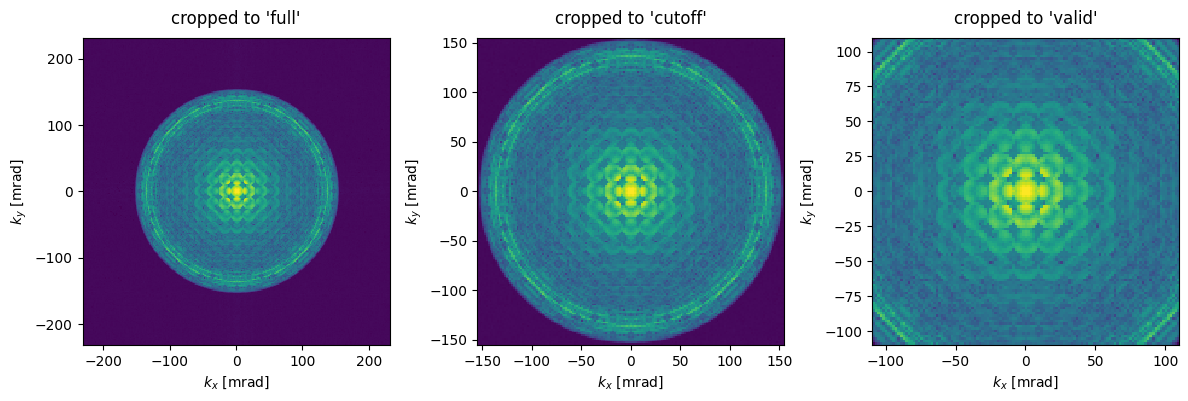

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

exit_wave_rough.diffraction_patterns(max_angle="full").show(
    ax=ax1, power=0.1, units="mrad", title="cropped to 'full'"
)

exit_wave_rough.diffraction_patterns(max_angle="cutoff").show(
    ax=ax2, power=0.1, units="mrad", title="cropped to 'cutoff'"
)

exit_wave_rough.diffraction_patterns(max_angle="valid").show(
    ax=ax3, power=0.1, units="mrad", title="cropped to 'valid'"
)

plt.tight_layout();

## Reciprocal-space sampling
Finally, we demonstrate the perhaps non-intuitive fact that the only real way to improve sampling in reciprocal space, i.e. decrease $\Delta k$, is to increase the size of the supercell in $x$ and $y$. 

Although some codes allow the sampling of diffraction patterns to be separately set, this is only numerically possibly by interpolation. In *ab*TEM we choose not to do this, but to retain the direct correspondence between the real-space extent of the potential and the reciprocal-space sampling.

Below we double the supercell and see that reciprocal-space sampling is correspondingly doubled.

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

tasks:   0%|          | 0/6 [00:00<?, ?it/s]

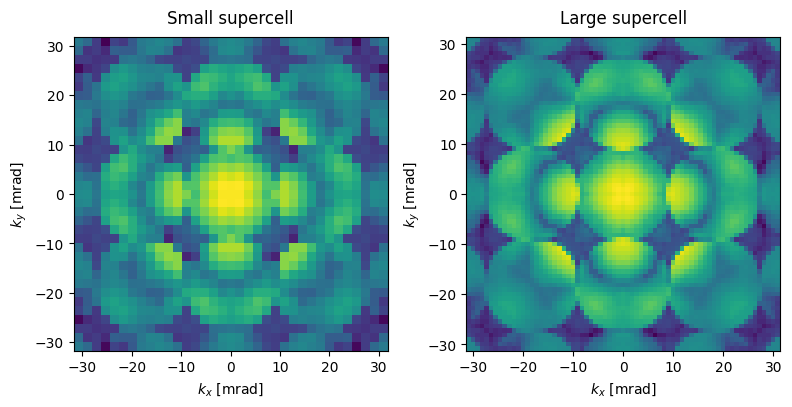

In [7]:
repeated_atoms = atoms.copy() * (2, 2, 1)

exit_wave_repeated = abtem.Probe(
    energy=100e3, semiangle_cutoff=9.5, sampling=0.08
).multislice(repeated_atoms)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

exit_wave_rough.diffraction_patterns(max_angle=30).show(
    ax=ax1, power=0.2, units="mrad", title="Small supercell"
)
exit_wave_repeated.diffraction_patterns(max_angle=30).show(
    ax=ax2, power=0.2, units="mrad", title="Large supercell"
)

plt.tight_layout()

In [8]:
print(f"Sampling of original cell = {exit_wave_rough.diffraction_patterns().sampling} 1/Å")
print(f"Sampling of doubled cell = {exit_wave_repeated.diffraction_patterns().sampling} 1/Å")

Sampling of original cell = (0.04901960784313726, 0.04901960784313726) 1/Å
Sampling of doubled cell = (0.02450980392156863, 0.02450980392156863) 1/Å
